## Lab | Unsupervised learning intro
Instructions

It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

- Check whether or not the song is in the Billboard Hot 200.<br>
- Collect the audio features from the Spotify API.<br>

After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.

In [14]:
# import libraries

from bs4 import BeautifulSoup
import requests
import spotipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.metrics import pairwise_distances_argmin_min

import plotly.express as px

### Exploring some datasets 

In [15]:
# load some datasets into Python so we can explore music a bit more

spotify_data = pd.read_csv('./data.csv')
genre = pd.read_csv('./data_by_genres.csv')
data_by_year = pd.read_csv('data_by_year.csv')

In [16]:
spotify_data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [17]:
genre.head()

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,20.859882,7
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7


In [18]:
data_by_year.head()

,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,1921,0.886896,0.418597,260537.166667,0.231815,0.344878,0.205710,-17.048667,0.073662,101.531493,0.379327,0.653333,2
1,1,1922,0.938592,0.482042,165469.746479,0.237815,0.434195,0.240720,-19.275282,0.116655,100.884521,0.535549,0.140845,10
2,1,1923,0.957247,0.577341,177942.362162,0.262406,0.371733,0.227462,-14.129211,0.093949,114.010730,0.625492,5.389189,0
3,1,1924,0.940200,0.549894,191046.707627,0.344347,0.581701,0.235219,-14.231343,0.092089,120.689572,0.663725,0.661017,10
4,1,1925,0.962607,0.573863,184986.924460,0.278594,0.418297,0.237668,-14.146414,0.111918,115.521921,0.621929,2.604317,5


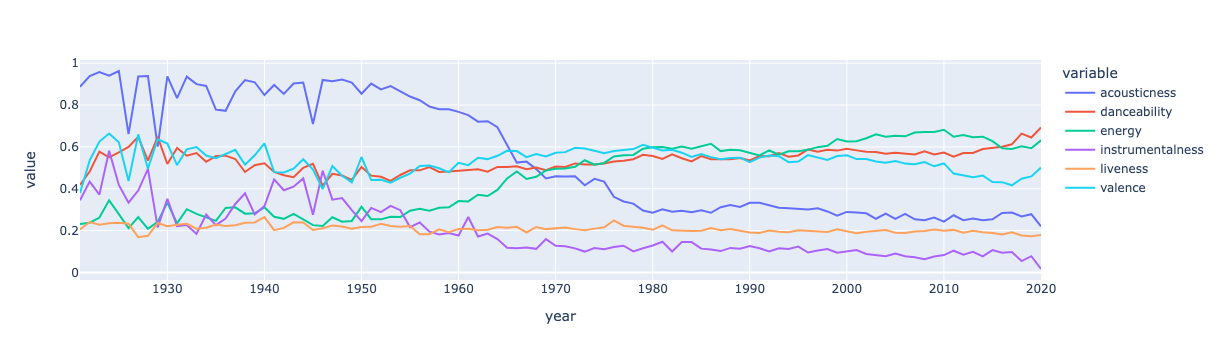

In [19]:
# let's see how music has changed over the years based on some variables

sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(data_by_year, x = 'year', y = sound_features)
fig.show()

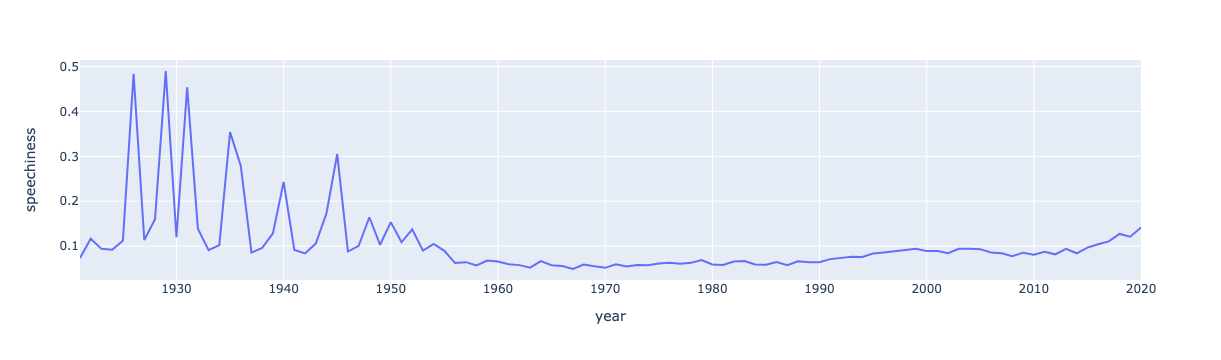

In [20]:
# how has the amount of speech in music changed over the years

fig = px.line(data_by_year, x = 'year', y = 'speechiness')
fig.show()

In [21]:
def get_billboard_top100():
    # Getting the html code of the web page
    r = requests.get('https://www.billboard.com/charts/hot-100')

    # Parsing the html code
    soup = BeautifulSoup(r.content, 'html.parser')

    # Find all the chart results rows
    chart_entries = soup.find_all('li', class_="lrv-u-width-100p")

    # Extract song titles and artists using list comprehensions
    songs = [chart.find('h3').get_text(strip=True) for chart in chart_entries if chart.find('h3')]
    artists = [chart.find('span').get_text(strip=True) for i, chart in enumerate(chart_entries) if i % 2 == 0]

    # Create a dataframe with the song and artist data
    df_billboard = pd.DataFrame({'Song': songs, 'Artist': artists})

    return df_billboard


In [83]:
# Call the function to get the Billboard top 100 songs
billboard_data = get_billboard_top100()
billboard_data

# I don't come back to this :(

,Song,Artist
0,Last Night,Morgan Wallen
1,Fast Car,Luke Combs
2,Calm Down,Rema & Selena Gomez
3,Flowers,Miley Cyrus
4,All My Life,Lil Durk Featuring J. Cole
...,...,...
95,"Angel, Pt. 1","Kodak Black, NLE Choppa, Jimin, JVKE & Muni Long"
96,Girl In Mine,Parmalee
97,Moonlight,Kali Uchis
98,Classy 101,Feid x Young Miko


### Connect to spotify and extract songs and audio features, apply the model

In [53]:
#initialise SpotiPy with user credentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="ab045655bea34c80a58b880808aff4e4",
                                                           client_secret="903f36e031a1471a8e8abc082f0c41e0"))

In [54]:
# Create a function to get tracks from the artists and store audio features in a dataframe

def get_audio_features(artist):
    """
    you input an artist and get a dataframe with 50 songs of this artist and its audio features
    """
    # get tracks from the artist
    results = sp.search(q = f'artist:{artist}', limit = 50)
    # get the track ids
    track_ids = [track['id'] for track in results['tracks']['items']]
    # get the song names
    song_names = [track['name'] for track in results['tracks']['items']]
    # get the audio features
    audio_features = sp.audio_features(track_ids)
    # store the audio features in a dataframe
    df = pd.DataFrame(audio_features)
    df['artist'] = artist
    df['song_name'] = song_names
    return df

In [55]:
# create loop and select artists you want to get songs from

artists = ['Tame Impala', 'Parra for Cuva', 'Monolink']

df = pd.DataFrame()

for artist in artists:
    df_artist = get_audio_features(artist)
    df = pd.concat([df, df_artist])
    
df = df.reset_index(drop=True)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist,song_name
0,0.640,0.740,4,-4.083,1,0.0284,0.01150,0.006780,0.1670,0.785,116.879,audio_features,6K4t31amVTZDgR3sKmwUJJ,spotify:track:6K4t31amVTZDgR3sKmwUJJ,https://api.spotify.com/v1/tracks/6K4t31amVTZD...,https://api.spotify.com/v1/audio-analysis/6K4t...,216320,4,Tame Impala,The Less I Know The Better
1,0.621,0.873,5,-3.067,0,0.0369,0.04060,0.000009,0.0824,0.873,97.960,audio_features,5hM5arv9KDbCHS0k9uqwjr,spotify:track:5hM5arv9KDbCHS0k9uqwjr,https://api.spotify.com/v1/tracks/5hM5arv9KDbC...,https://api.spotify.com/v1/audio-analysis/5hM5...,237800,4,Tame Impala,Borderline
2,0.470,0.809,8,-6.740,1,0.0495,0.27200,0.006710,0.0491,0.490,151.836,audio_features,52ojopYMUzeNcudsoz7O9D,spotify:track:52ojopYMUzeNcudsoz7O9D,https://api.spotify.com/v1/tracks/52ojopYMUzeN...,https://api.spotify.com/v1/audio-analysis/52oj...,363240,4,Tame Impala,"New Person, Same Old Mistakes"
3,0.424,0.615,9,-6.217,0,0.0325,0.01580,0.000389,0.0844,0.155,77.935,audio_features,5M4yti0QxgqJieUYaEXcpw,spotify:track:5M4yti0QxgqJieUYaEXcpw,https://api.spotify.com/v1/tracks/5M4yti0QxgqJ...,https://api.spotify.com/v1/audio-analysis/5M4y...,318591,4,Tame Impala,Eventually
4,0.602,0.881,1,-5.875,0,0.0443,0.00462,0.026600,0.1110,0.577,125.012,audio_features,2X485T9Z5Ly0xyaghN73ed,spotify:track:2X485T9Z5Ly0xyaghN73ed,https://api.spotify.com/v1/tracks/2X485T9Z5Ly0...,https://api.spotify.com/v1/audio-analysis/2X48...,467587,4,Tame Impala,Let It Happen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.796,0.422,4,-14.228,0,0.0484,0.16300,0.627000,0.6470,0.164,117.993,audio_features,6EmLxgiaK26sBGBmCLEsgS,spotify:track:6EmLxgiaK26sBGBmCLEsgS,https://api.spotify.com/v1/tracks/6EmLxgiaK26s...,https://api.spotify.com/v1/audio-analysis/6EmL...,488345,4,Monolink,Under Dark
146,0.673,0.769,11,-9.003,0,0.0423,0.09610,0.190000,0.0936,0.282,122.997,audio_features,38SuUk02USbWfH97FWHaxV,spotify:track:38SuUk02USbWfH97FWHaxV,https://api.spotify.com/v1/tracks/38SuUk02USbW...,https://api.spotify.com/v1/audio-analysis/38Su...,463035,4,Monolink,Sinner
147,0.808,0.558,11,-9.695,0,0.0596,0.35100,0.648000,0.1020,0.339,120.007,audio_features,3lchYylgQrEHvabP3rLAjX,spotify:track:3lchYylgQrEHvabP3rLAjX,https://api.spotify.com/v1/tracks/3lchYylgQrEH...,https://api.spotify.com/v1/audio-analysis/3lch...,358427,4,Monolink,Sirens
148,0.613,0.736,5,-11.947,0,0.0391,0.00950,0.711000,0.1510,0.134,119.994,audio_features,1JhsoApJ4T4uVhdgeyuAsq,spotify:track:1JhsoApJ4T4uVhdgeyuAsq,https://api.spotify.com/v1/tracks/1JhsoApJ4T4u...,https://api.spotify.com/v1/audio-analysis/1Jhs...,270539,4,Monolink,Don't Hold Back - Edit


In [56]:
df.artist.value_counts()

Tame Impala       50
Parra for Cuva    50
Monolink          50
Name: artist, dtype: int64

In [57]:
# select the features that we need
x = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

# scale the data
scaler = StandardScaler()
x_prep = scaler.fit_transform(x)

# train and predict
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_prep)
clusters = kmeans.predict(x_prep)

#create new dataframe with title, artist and the cluster it is part of 
scaled_df = pd.DataFrame(x_prep, columns = x.columns)
scaled_df['song_name'] = df['song_name']
scaled_df['artist'] = df['artist']
scaled_df['cluster'] = clusters
scaled_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_name,artist,cluster
0,0.058541,0.570976,-0.504009,1.168577,1.027032,-0.722898,-0.910394,-1.161429,0.001010,2.025073,-0.111581,The Less I Know The Better,Tame Impala,2
1,-0.061059,1.290885,-0.225037,1.400774,-0.973680,-0.465218,-0.792652,-1.180263,-0.630202,2.407483,-1.027608,Borderline,Tame Impala,2
2,-1.011567,0.944462,0.611878,0.561344,1.027032,-0.083246,0.143620,-1.161624,-0.878658,0.743128,1.580980,"New Person, Same Old Mistakes",Tame Impala,2
3,-1.301126,-0.105630,0.890850,0.680871,-0.973680,-0.598605,-0.892996,-1.179206,-0.615280,-0.712640,-1.997185,Eventually,Tame Impala,1
4,-0.180660,1.334187,-1.340925,0.759032,-0.973680,-0.240885,-0.938232,-1.106298,-0.416814,1.121193,0.282206,Let It Happen,Tame Impala,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.040523,-1.150309,-0.504009,-1.149971,-0.973680,-0.116592,-0.297407,0.563757,3.582353,-0.673529,-0.057643,Under Dark,Monolink,1
146,0.266268,0.727949,1.448794,0.044156,-0.973680,-0.301516,-0.568092,-0.651790,-0.546637,-0.160752,0.184643,Sinner,Monolink,1
147,1.116060,-0.414162,1.448794,-0.113995,-0.973680,0.222938,0.463264,0.622170,-0.483964,0.086946,0.039872,Sirens,Monolink,1
148,-0.111417,0.549325,-0.225037,-0.628669,-0.973680,-0.398524,-0.918486,0.797409,-0.118368,-0.803897,0.039242,Don't Hold Back - Edit,Monolink,1


In [58]:
# check the audio features for a particular song

scaled_df[scaled_df.song_name == 'Sinner']

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_name,artist,cluster
146,0.266268,0.727949,1.448794,0.044156,-0.97368,-0.301516,-0.568092,-0.65179,-0.546637,-0.160752,0.184643,Sinner,Monolink,1


In [59]:
#drop the duplicates - I removed this for now as it was preventing me from visualising my clusters

# scaled_df = scaled_df.drop_duplicates()
# len(scaled_df)

In [60]:
# let's see which songs are in cluster 2

scaled_df[scaled_df.cluster == 2]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_name,artist,cluster
0,0.058541,0.570976,-0.504009,1.168577,1.027032,-0.722898,-0.910394,-1.161429,0.001010,2.025073,-0.111581,The Less I Know The Better,Tame Impala,2
1,-0.061059,1.290885,-0.225037,1.400774,-0.973680,-0.465218,-0.792652,-1.180263,-0.630202,2.407483,-1.027608,Borderline,Tame Impala,2
2,-1.011567,0.944462,0.611878,0.561344,1.027032,-0.083246,0.143620,-1.161624,-0.878658,0.743128,1.580980,"New Person, Same Old Mistakes",Tame Impala,2
4,-0.180660,1.334187,-1.340925,0.759032,-0.973680,-0.240885,-0.938232,-1.106298,-0.416814,1.121193,0.282206,Let It Happen,Tame Impala,2
5,-2.062792,1.437031,-1.061953,1.564181,-0.973680,0.156245,-0.844847,0.586010,-0.424275,0.747474,1.468262,Feels Like We Only Go Backwards,Tame Impala,2
6,-0.596114,-0.587373,-1.619897,-0.127479,1.027032,3.903210,-0.313591,1.175703,-0.289974,0.499776,2.344634,Nangs,Tame Impala,2
9,0.631364,0.159600,-1.619897,0.850676,1.027032,-0.668330,-0.944503,-0.206738,-0.252669,1.486221,-0.056432,Is It True,Tame Impala,2
10,0.190731,1.269233,-0.225037,0.849991,1.027032,-0.571321,-0.641327,1.389884,1.724531,2.090256,0.377057,Disciples,Tame Impala,2
11,-1.622159,-0.138107,-1.619897,0.501923,1.027032,-0.625889,-0.519944,-1.179100,-0.681684,0.152130,2.942455,Yes I'm Changing,Tame Impala,2
12,-0.810135,0.349049,-0.225037,0.838335,1.027032,-0.574353,-0.934671,-1.180288,0.030854,0.152130,-0.395070,Love/Paranoia,Tame Impala,2


## Some clustering visualisations

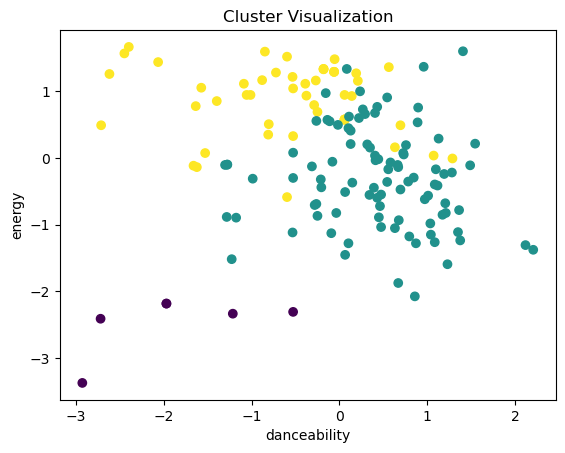

In [63]:
# let's try one way of visualising the clusters

import matplotlib.pyplot as plt

# Select the features to visualise
feature1 = 'danceability'
feature2 = 'energy'

# Plotting the clusters
plt.scatter(scaled_df[feature1], scaled_df[feature2], c = clusters)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Cluster Visualization')
plt.show()


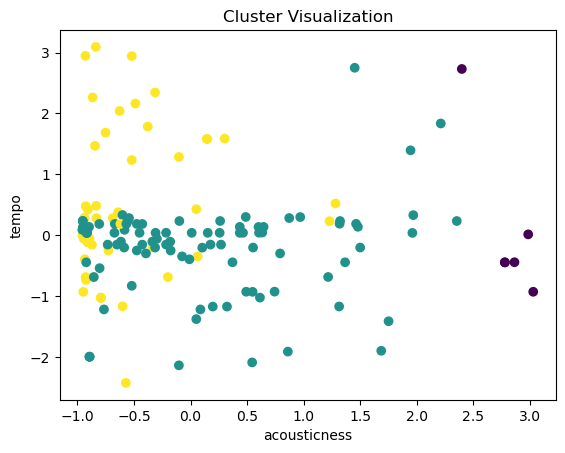

In [64]:
# and now try with some other features

feature1 = 'acousticness'
feature2 = 'tempo'

# Plotting the clusters
plt.scatter(scaled_df[feature1], scaled_df[feature2], c = clusters)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Cluster Visualization')
plt.show()

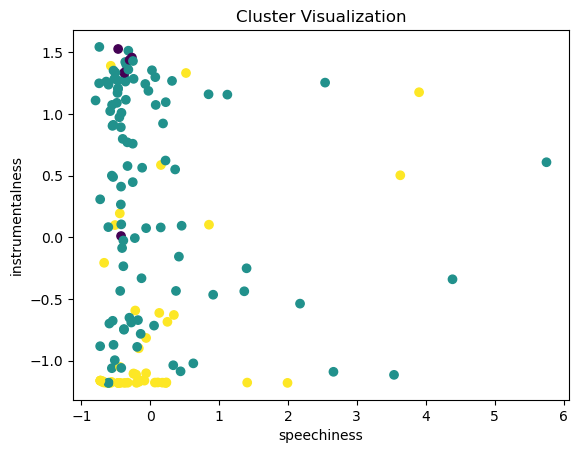

In [66]:
# and some others

import matplotlib.pyplot as plt


feature1 = 'speechiness'
feature2 = 'instrumentalness'


plt.scatter(scaled_df[feature1], scaled_df[feature2], c = clusters)
plt.xlabel(feature1)
plt.ylabel(feature2)

plt.title('Cluster Visualization')
plt.show()

In [ ]:
#### there are a couple of options as to what will give you the best combination, I am trying trial and error

In [67]:
print(scaled_df.shape)

(150, 14)


In [68]:
print(scaled_df.isnull().sum())

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
song_name           0
artist              0
cluster             0
dtype: int64


In [69]:
print(len(clusters))


150


In [87]:
scaled_df.dtypes

danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
song_name            object
artist               object
cluster               int32
dtype: object

In [90]:
columns_to_drop = ['song_name', 'artist']
scaled_df.drop(columns_to_drop, axis = 1, inplace = True)

### Choosing the best K

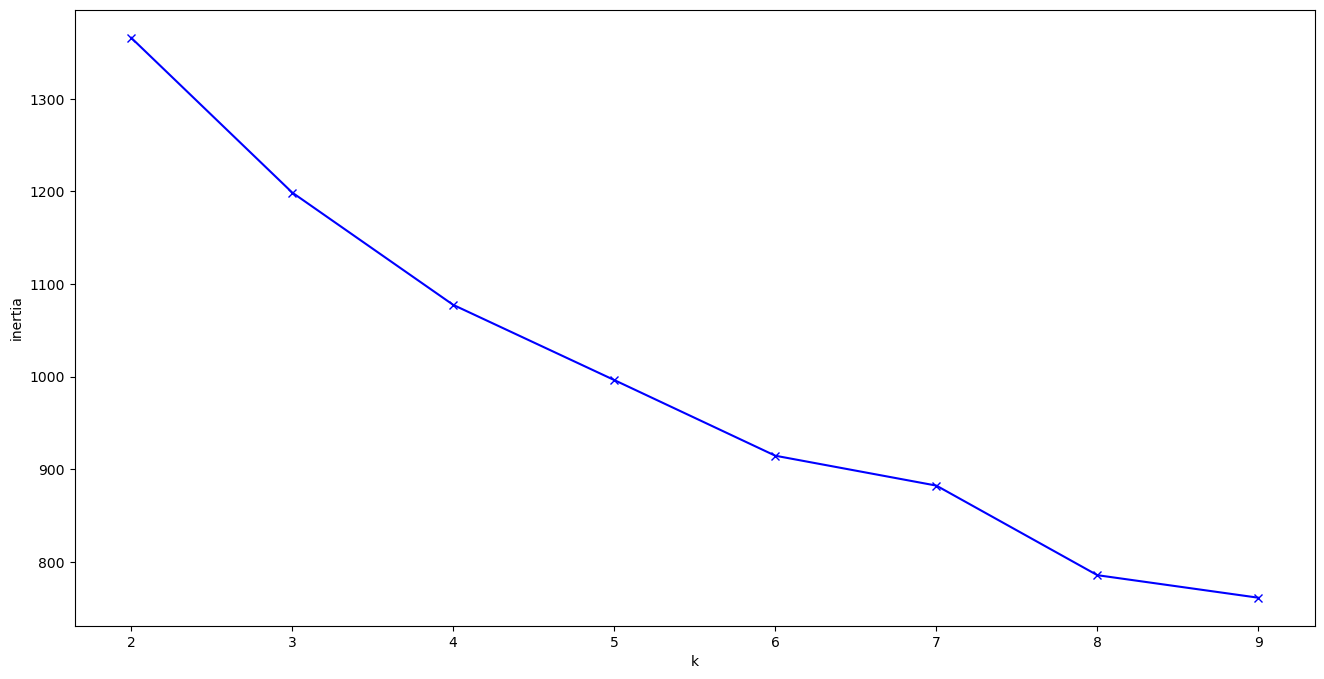

In [91]:
K = range(2, 10)

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

inertia

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

Looks like 8 might be the best the best K

### Silhouette Score

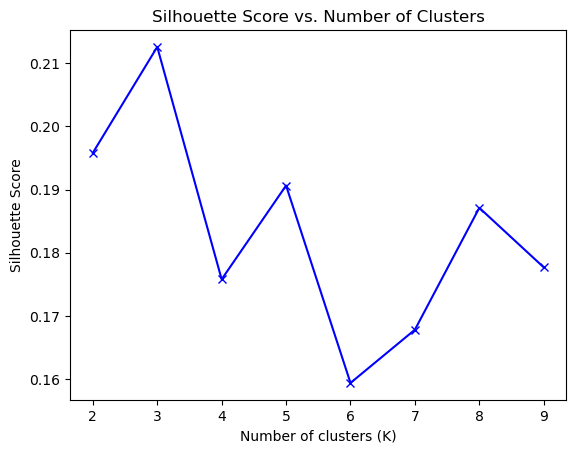

In [94]:
from sklearn.metrics import silhouette_score

K = range(2, 10)

silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    labels = kmeans.labels_
    score = silhouette_score(scaled_df, labels)
    silhouette_scores.append(score)

# Plotting the silhouette scores
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [95]:
K = range(2, 12)
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(scaled_df)
    labels = kmeans.labels_
    score = silhouette_score(scaled_df, labels)
    silhouette_scores.append(score)

for k, score in zip(K, silhouette_scores):
    print(f"Silhouette Score for {k} clusters: {score}")

Silhouette Score for 2 clusters: 0.19581165491660818
Silhouette Score for 3 clusters: 0.2125804998646361
Silhouette Score for 4 clusters: 0.17581495390035973
Silhouette Score for 5 clusters: 0.16151983690942537
Silhouette Score for 6 clusters: 0.16955482275775355
Silhouette Score for 7 clusters: 0.18087744966713393
Silhouette Score for 8 clusters: 0.18271492741511655
Silhouette Score for 9 clusters: 0.1701032868329998
Silhouette Score for 10 clusters: 0.18092588541714844
Silhouette Score for 11 clusters: 0.17308940327033098


Here 8 looks like the best K

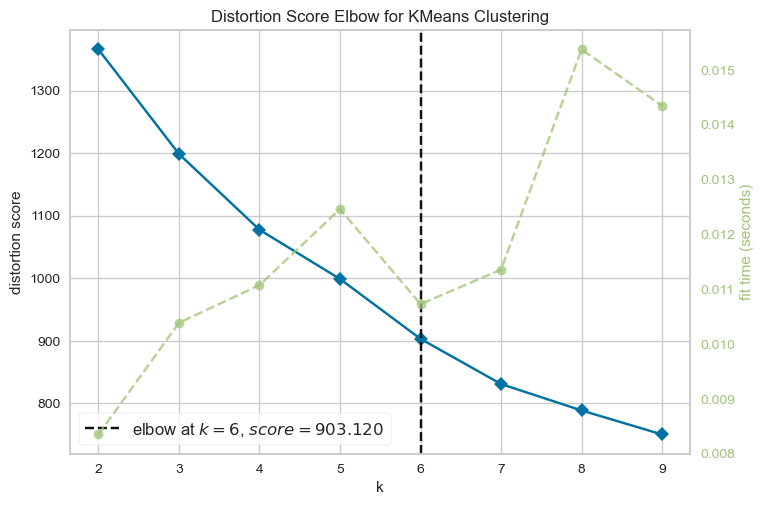

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [97]:
from yellowbrick.cluster import KElbowVisualizer

# Let's try the KElbowVisualizer
visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(scaled_df)    # Fit the data to the visualizer
visualizer.poof()   

Here we see the recommended K is 6

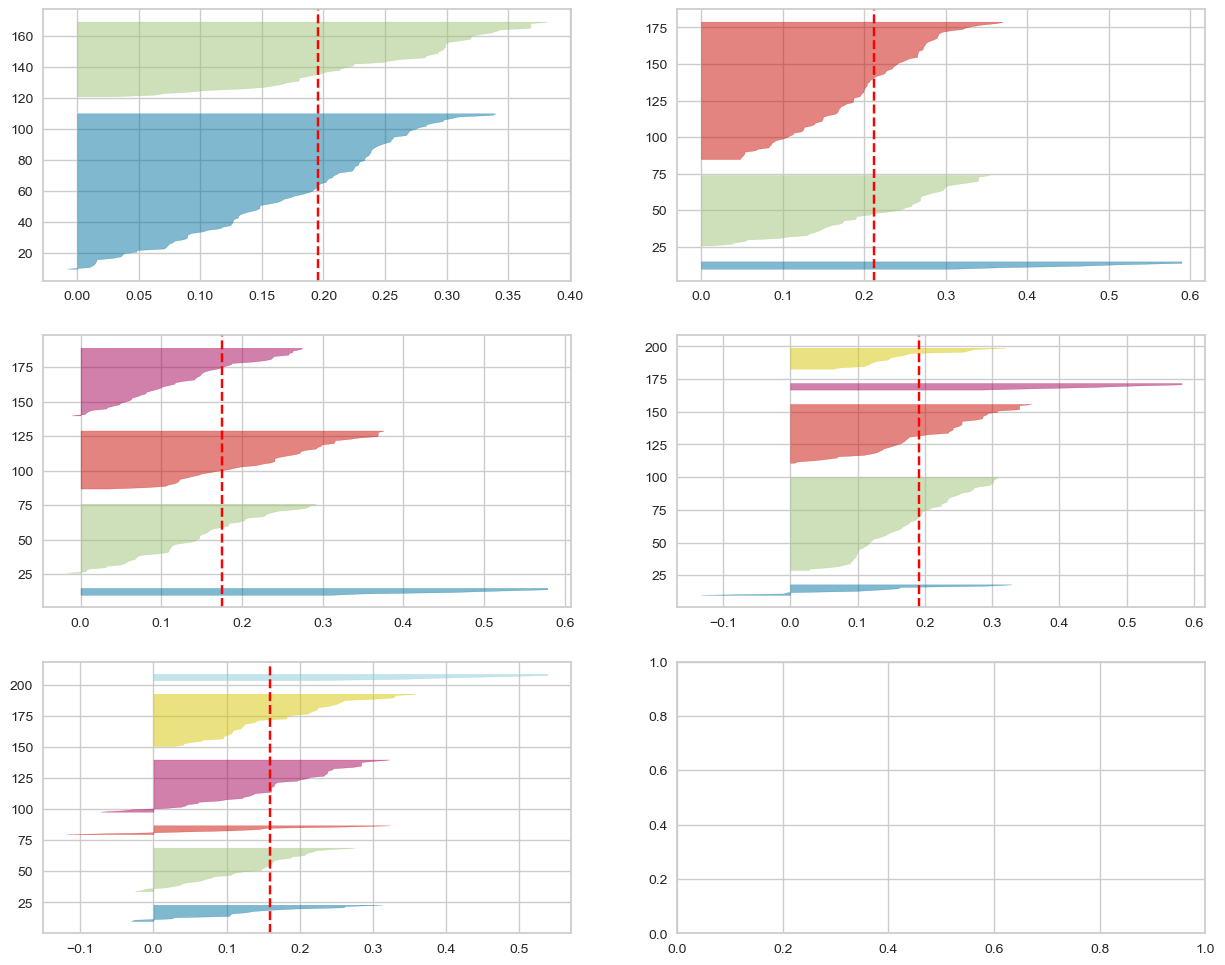

In [101]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

fig, ax = plt.subplots(3, 2, figsize=(15, 12))

for idx, i in enumerate([2, 3, 4, 5, 6]):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(idx, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(scaled_df)

### Song recommendation

In [84]:
song_name = input('Choose a song: ')

# searching for the song in spotipy and getting the audio features
results = sp.search(q = f'track:{song_name}', limit = 1)
if not results['tracks']['items']:
    print("Sorry, I can't find the song you're looking for")
#else:
track_id = results['tracks']['items'][0]['id']
audio_features = sp.audio_features(track_id)

# put it into a dataframe
df_ = pd.DataFrame(audio_features)
new_features = df_[x.columns]

# scale the audio features
scaled_x = scaler.transform(new_features)

# assign the cluster to the song
cluster = kmeans.predict(scaled_x)

filtered_df = scaled_df[scaled_df['cluster'] == cluster[0]][x.columns]
closest, _ = pairwise_distances_argmin_min(scaled_x, filtered_df)
scaled_df.loc[closest[0]]['song_name'], scaled_df.loc[closest[0]]['artist']

if filtered_df.empty:
        print("Sorry, I can't find something similar.")
else:
        # Finding the closest song in the same cluster to recommend
        closest, _ = pairwise_distances_argmin_min(scaled_x, filtered_df)
        recommended_song = scaled_df.loc[closest[0]]

        print("Recommended song:")
        print("Title:", recommended_song['song_name'])
        print("Artist:", recommended_song['artist'])

Choose a song:  jingle bells


Recommended song:
Title: Instant Destiny
Artist: Tame Impala


In [80]:
# I had some issues with the function

# def recommend_song():
    
#     # get song id
#     song_name = input('Choose a song: ')
#     results = sp.search(q=f'track:{song_name}', limit=1)
#     track_id = results['tracks']['items'][0]['id']
    
#     # get song features with the obtained id
#     audio_features = sp.audio_features(track_id)
    
#     # create dataframe
#     df_ = pd.DataFrame(audio_features)
#     new_features = df_[x.columns]
    
#     # scale features
#     scaled_x = scaler.transform(new_features)
    
#     # predict cluster
#     cluster = kmeans.predict(scaled_x)
    
#     # filter dataset to predicted cluster
#     filtered_df = scaled_df[scaled_df['cluster'] == cluster[0]][x.columns]
    
#     # get closest song from filtered dataset
#     closest, _ = pairwise_distances_argmin_min(scaled_x, filtered_df)
    
#     # return it in a readable way
#     #print('\n [RECOMMENDED SONG]')
    

#     if filtered_df.empty:
#             print("Can't find something similar.")
#     else:
#             # Finding the closest song in the same cluster to recommend
#             closest, _ = pairwise_distances_argmin_min(scaled_x, filtered_df)
#             recommended_song = scaled_df.loc[closest[0]]

#             print("Recommended song:")
#             print("Title:", recommended_song['song_name'])
#             print("Artist:", recommended_song['artist'])

#             return ' - '.join([scaled_df.loc[closest]['song_name'].values[0], scaled_df.loc[closest]['artist'].values[0]])

In [82]:
recommend_song()

Choose a song:  return to oz


Recommended song:
Title: Sidetracked Soundtrack - Unreleased Demo
Artist: Tame Impala


'Sidetracked Soundtrack - Unreleased Demo - Tame Impala'